# Классификация отзывов IMDB

Будем решать задачу бинарной классификации отзывов IMDB к фильмам. Имеется обучающая выборка с размеченными отзывами, по 12500 отзывов известно, что они хорошие, еще про 12500 – что они плохие. Здесь уже не так просто сразу приступить к машинному обучению, потому что готовой матрицы $X$ нет  – ее надо приготовить. Будем использовать самый простой подход – мешок слов ("Bag of words"). При таком подходе признаками отзыва будут индикаторы наличия в нем каждого слова из всего корпуса, где корпус – это множество всех отзывов. Идея иллюстрируется картинкой

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRFzF812gEF_ko3HfaHPHf5sUWRT6K54qE0wQ&usqp=CAU" width=500>

In [17]:
# отключим всякие предупреждения Anaconda
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.linear_model import LogisticRegression

**Загрузим данные [отсюда](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) (это прямая ссылка на скачивание, а [вот](http://ai.stanford.edu/~amaas/data/sentiment/) описание набора данных). В обучающей и тестовой выборках по 12500 тысяч хороших и плохих отзывов к фильмам.**

In [18]:
# поменяйте путь к файлу
reviews_train = load_files(
    "/Users/iakubovskii/Machine_Learning/RANEPA/Data_large/aclImdb/train",
    categories=["pos", "neg"],
)
text_train, y_train = reviews_train.data, reviews_train.target

In [19]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


In [20]:
# поменяйте путь к файлу
reviews_test = load_files(
    "/Users/iakubovskii/Machine_Learning/RANEPA/Data_large/aclImdb/test"
)
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


In [21]:
# Пример отзыва
print(text_train[1])

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [22]:
y_train[1]  # плохой отзыв (0 метка)

0

In [23]:
text_train[2], y_test[2] # хороший отзыв (1 метка)

(b'Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live part of his life differently, but ends up realizing that what he had was going to be just as good or maybe even better. The movie shows us that we ought to take advantage of the opportunities we have, not the ones we do not or cannot have. If U can get this movie on video for around $10, it\xc2\xb4d be an investment!',
 1)

## Простой подсчет слов

**Составим словарь всех слов с помощью CountVectorizer.**

In [24]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

**Посмотрим на примеры полученных "слов" (лучше их называть токенами). Видим, что многие важные этапы обработки текста мы тут пропустили.**

In [25]:
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']
['pincher', 'pinchers', 'pinches', 'pinching', 'pinchot', 'pinciotti', 'pine', 'pineal', 'pineapple', 'pineapples', 'pines', 'pinet', 'pinetrees', 'pineyro', 'pinfall', 'pinfold', 'ping', 'pingo', 'pinhead', 'pinheads', 'pinho', 'pining', 'pinjar', 'pink', 'pinkerton', 'pinkett', 'pinkie', 'pinkins', 'pinkish', 'pinko', 'pinks', 'pinku', 'pinkus', 'pinky', 'pinnacle', 'pinnacles', 'pinned', 'pinning', 'pinnings', 'pinnochio', 'pinnocioesque', 'pino', 'pinocchio', 'pinochet', 'pinochets', 'pinoy', 'pinpoint', 'pinpoints', 'pins', 'pinsent']


**Закодируем предложения из текстов обучающей выборки индексами входящих слов. Используем разреженный формат.**

In [26]:
X_train = cv.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

**Посмотрим, как преобразование подействовало на одно из предложений.**

In [27]:
print(text_train[19726])

b'This movie is terrible but it has some good effects.'


In [28]:
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
       66562], dtype=int32)

In [29]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
        66562], dtype=int32))

**Преобразуем так же тестовую выборку.**

In [30]:
X_test = cv.transform(text_test)

**Обучим логистическую регрессию.**

In [31]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7) # n_jobs=-1 - задействуем все ядра компьютера (кроме 1)
logit.fit(X_train, y_train)

CPU times: user 59.1 ms, sys: 105 ms, total: 164 ms
Wall time: 9.58 s


LogisticRegression(n_jobs=-1, random_state=7)

**Посмотрим на доли правильных ответов на обучающей и тестовой выборках.**

In [32]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3),

(0.981, 0.864)

In [33]:
# Красиво изобразим коэффициенты
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(
        np.arange(1, 1 + 2 * n_top_features),
        feature_names[interesting_coefficients],
        rotation=60,
        ha="right",
    );

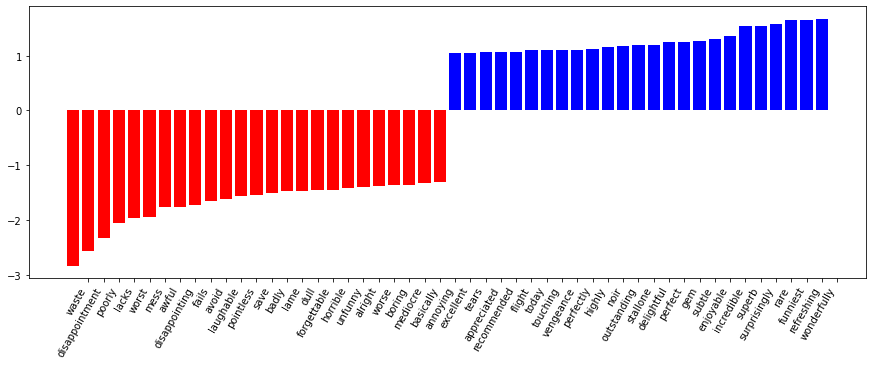

In [34]:
visualize_coefficients(logit, cv.get_feature_names())

In [35]:
cv.get_feature_names() 

['00',
 '000',
 '0000000000001',
 '00001',
 '00015',
 '000s',
 '001',
 '003830',
 '006',
 '007',
 '0079',
 '0080',
 '0083',
 '0093638',
 '00am',
 '00pm',
 '00s',
 '01',
 '01pm',
 '02',
 '020410',
 '029',
 '03',
 '04',
 '041',
 '05',
 '050',
 '06',
 '06th',
 '07',
 '08',
 '087',
 '089',
 '08th',
 '09',
 '0f',
 '0ne',
 '0r',
 '0s',
 '10',
 '100',
 '1000',
 '1000000',
 '10000000000000',
 '1000lb',
 '1000s',
 '1001',
 '100b',
 '100k',
 '100m',
 '100min',
 '100mph',
 '100s',
 '100th',
 '100x',
 '100yards',
 '101',
 '101st',
 '102',
 '102nd',
 '103',
 '104',
 '1040',
 '1040a',
 '1040s',
 '105',
 '1050',
 '105lbs',
 '106',
 '106min',
 '107',
 '108',
 '109',
 '10am',
 '10lines',
 '10mil',
 '10min',
 '10minutes',
 '10p',
 '10pm',
 '10s',
 '10star',
 '10th',
 '10x',
 '10yr',
 '11',
 '110',
 '1100',
 '11001001',
 '1100ad',
 '111',
 '112',
 '1138',
 '114',
 '1146',
 '115',
 '116',
 '117',
 '11f',
 '11m',
 '11th',
 '12',
 '120',
 '1200',
 '1200f',
 '1201',
 '1202',
 '123',
 '12383499143743701',
 '1

**Подберем коэффициент регуляризации для логистической регрессии. Используем `sklearn.pipeline`, поскольку `CountVectorizer` правильно применять только на тех данных, на которых в текущий момент обучается модель (чтоб не "подсматривать" в тестовую выборку и не считать по ней частоты вхождения слов). В данном случае `pipeline` задает последовательность действий: применить `CountVectorizer`, затем обучить логистическую регрессию.**

In [36]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(
    CountVectorizer(), LogisticRegression(n_jobs=-1, random_state=7)
)

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

0.86408
CPU times: user 9.31 s, sys: 217 ms, total: 9.53 s
Wall time: 12.9 s


In [37]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {"logisticregression__C": np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(
    text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1, return_train_score=True
)

grid_logit.fit(text_train, y_train)

CPU times: user 4.55 s, sys: 679 ms, total: 5.22 s
Wall time: 1min 33s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=7))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
             return_train_score=True)

**Лучшее значение C и соответствующее качество на кросс-валидации:**

In [38]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.1}, 0.8854799308363024)

In [39]:
# Нарисуем сетку 
def plot_grid_scores(grid, param_name):
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_train_score"],
        color="green",
        label="train",
    )
    plt.plot(
        grid.param_grid[param_name],
        grid.cv_results_["mean_test_score"],
        color="red",
        label="test",
    )
    plt.legend();

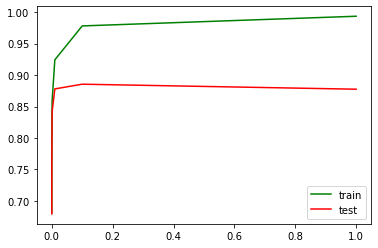

In [40]:
plot_grid_scores(grid_logit, "logisticregression__C")

In [41]:
# На валидационной выборке
grid_logit.score(text_test, y_test)

0.87812

**Теперь то же самое, но со случайным лесом. Видим, что с логистической регрессией мы достигаем большей доли правильных ответов меньшими усилиями**

In [42]:
%%time
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=17)
forest.fit(X_train, y_train)

CPU times: user 3min 4s, sys: 1.39 s, total: 3min 5s
Wall time: 57.8 s


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=17)

In [43]:
round(forest.score(X_test, y_test), 3)

0.855

## Стоп-слова, лемматизация, tf-idf
После токенизации мы обычно нормализуем данные. Здесь речь идет о стемминге и/или лемматизации; это похожие процессы, используемые для обработки различных форм слова. О разнице между ними можно прочитать [здесь](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html). Однако, перед лемматизацией, как правило, мы удаляем еще и стоп-слова - токены, которые только лишь зашумляют данные и не несут никакой смысловой нагрузки (однако, кстати итд.). Чтобы подгрузить русские стоп-слова, используют пакеты nltk, gensim, spaCy и другие. 

Стоит сказать, что простого мешка слов (bag of words) бывает недостаточно для точного прогнозирования, поскольку присутствие одних и тех же слов в документах может говорить лишь о том, что они в целом распространены. Таким образом, нам нужно придумать некую метрику, которая бы учитывала этот факт. Один из примеров - **term frequency inverse document frequence**:

$$ \Large TF-IDF = TF(t,d) * IDF(t) = \frac{n_i}{\sum_{i=1}^{|D|}n_i} * log(\frac {|D|} {1 + |{d: t \in d}|}) $$

$n_t$ - количество вхождений слова $t$ в документ $d$

$\sum_{i=1}^{|D|}n_i$ - сколько всего слов в данном документе $d$

$|{d: t \in d}|$ - в скольких документах встречается слово $t$, 

$|D|$ - количество документов

Большой вес в TF-IDF получат слова с высокой частотой в пределах конкретного документа и с низкой частотой употреблений в других документах.

In [44]:
# Сравним CountVectoriser и TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english') # remove stop words
X_train_tfidf = tfidfvectorizer.fit_transform(text_train)
import pandas as pd
df_countvect = pd.DataFrame(data = X_train.toarray(),
                            index = np.arange(X_train.shape[0]),
                            columns = cv.get_feature_names())
df_tfidfvect = pd.DataFrame(data = X_train_tfidf.toarray(),
                            index = np.arange(X_train.shape[0]),
                            columns = tfidfvectorizer.get_feature_names())

In [45]:
df_countvect.values[:10, :].sum(axis=1)

array([131, 192,  79, 147, 295,  52, 108, 262, 441,  51])

In [46]:
df_tfidfvect.values[:10, :].sum(axis=1)

array([6.76335192, 7.09854409, 4.75552953, 7.07781462, 8.8627557 ,
       5.19814691, 6.08974441, 8.65806666, 9.94668204, 4.38918646])

In [47]:
np.corrcoef(df_countvect.values[:10, :].sum(axis=1), df_tfidfvect.values[:10, :].sum(axis=1))

array([[1.        , 0.95626774],
       [0.95626774, 1.        ]])

In [48]:
text_pipe_logit_tfidf = make_pipeline(
    TfidfVectorizer(analyzer='word',stop_words= 'english'), 
    LogisticRegression(n_jobs=-1, random_state=7)
)

text_pipe_logit_tfidf.fit(text_train, y_train)
print(text_pipe_logit_tfidf.score(text_test, y_test))

0.879


In [49]:
# Улучшили!

In [50]:
param_grid_logit_tfidf = {"logisticregression__C": np.logspace(-5, 0, 6)}
grid_logit_tfidf = GridSearchCV(
    text_pipe_logit_tfidf, param_grid_logit_tfidf, cv=5, n_jobs=-1, return_train_score=True
)

grid_logit_tfidf.fit(text_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('logisticregression',
                                        LogisticRegression(n_jobs=-1,
                                                           random_state=7))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
             return_train_score=True)

In [51]:
grid_logit_tfidf.best_params_, grid_logit_tfidf.best_score_

({'logisticregression__C': 1.0}, 0.8873999999999999)

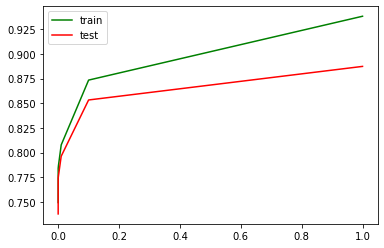

In [52]:
plot_grid_scores(grid_logit_tfidf, "logisticregression__C")

## 1.3 Удалим ненужные символы и избавим наш текст от мусора

In [71]:
# !pip install clean-text
from cleantext import clean
def clean_text(text):
    clean_text = clean(text, 
      fix_unicode=True, 
      to_ascii=True, 
      lower=True, 
      no_line_breaks=True,
      no_urls=True, 
      no_numbers=True, 
      no_digits=True, 
      no_currency_symbols=True, 
      no_punct=True, 
      replace_with_punct="", 
      replace_with_url="", 
      replace_with_number="", 
      replace_with_digit="", 
      replace_with_currency_symbol="",
      lang='en')
    return clean_text

In [55]:
len(text_train)

25000

In [56]:
text_train[100]

b"(spoilers)<br /><br />I shoulda figured. The dvd didn't even show the time or how long it was. I thought Wild Cardz was the worst anime movie I'd ever seen. This one is much worse. Makes no sense. Thrown together plot. All so we can see oversized breasts on a figure that doesn't support them. <br /><br />It had to of been a student film. That musta gotten a C grade<br /><br />2/10<br /><br />Quality: 1/10 Entertainment: 6/10 (until I found out it wasn't going to end.) the ending made no darn sense<br /><br />Replayable: 0/10"

In [57]:
clean_text(text_train[100])

'bspoilers<br ><br >i shoulda figured the dvd didnt even show the time or how long it was i thought wild cardz was the worst anime movie id ever seen this one is much worse makes no sense thrown together plot all so we can see oversized breasts on a figure that doesnt support them <br ><br >it had to of been a student film that musta gotten a c grade<br ><br ><number><number><br ><br >quality <number><number> entertainment <number><number> until i found out it wasnt going to end the ending made no darn sense<br ><br >replayable <number><number>'

In [59]:
%%time
text_train_cleaned = list(map(clean_text, text_train))
text_test_cleaned = list(map(clean_text, text_test))

CPU times: user 2min 31s, sys: 698 ms, total: 2min 32s
Wall time: 2min 35s


In [73]:
text_pipe_logit_tfidf = make_pipeline(
    TfidfVectorizer(analyzer='word',stop_words= 'english'), 
    LogisticRegression(n_jobs=-1, random_state=7)
)

text_pipe_logit_tfidf.fit(text_train_cleaned, y_train)
print(text_pipe_logit_tfidf.score(text_test_cleaned, y_test))

0.69428
